# About 

    Building a machine learning model to predict the house prices in metropolitian cities of India, given some features like the house area, area address, amenities etc. The Dataset used for modelling has in it some additional engineered features by using the address. 

# Additional Features 

**The Link to the notebook where these features are created:**  https://www.kaggle.com/code/virajkadam/geocoding-and-feature-eng-housing-price-dataset


**The Idea is to include features which might have predictive power in determining housing prices like:**

    1) How modified is the area?
    2) What is the population in the area. How has been the population growth throughout the years?
    3) When did the area start experiencing growth in urbanisation?
    4) How is the settlements density in the area? How has it varied throughout the years?  

    Not inculuded but can be:
    5) Density of roads.
    6) Other demographic data like median income, education level etc.
    7) Proximity to the Airport, Markets, Railway stations,Highways etc.
    8) Availablity of water , public transport etc.


**The first step is to geocode housing addresses , which gives a geological coordinate (latitude,longitude) to each address.
We take a buffer of 3000 meters around each geological - coordinate and calculate stats for this region using public dataset available on google earth engine. Description of some of the features given below.**

    1) GHm (aggregation: mean): The global Human Modification dataset (gHM) provides a cumulative measure of human modification of terrestrial lands globally at 1 square-kilometer resolution. The gHM values range from 0.0-1.0 and are calculated by estimating the proportion of a given location (pixel) that is modified, the estimated intensity of modification associated with a given type of human modification or "stressor".

    2)No Builtup,2000-2014,1990-2000,1975-1990,Bf_1975,Water Sf: (aggregation: frequency histogram): These are built up values taken from Global Human Settlements Layer, and the values denotes the built ups(Human settlements) in each time epoch.

    3)population_1975,population_2000,population_2015: Approximate human population in the selected area.The dataset depicts the distribution and density of population, expressed as the number of people per cell, for reference epochs: 1975, 2000, 2015

    4) RUR_year,LDC_year,HDC_year,Inhabited areas_year' (aggregation: frequency histogram) : For each of the year among 1975,1990,2000,2015 the features denotes the count of pixels with given density of settlement. RUR denotes Rural, LDC denotes Low Density Clusters, HDC denotes high density clusters, Inhabited areas denotes areas without human habitation for each of the corresponding years.

# Adding data from census housing dataset 

**The Link to the notebook where these features are created:**  : https://www.kaggle.com/code/virajkadam/geocoding-and-feature-eng-housing-price-dataset
https://www.kaggle.com/code/virajkadam/feature-engineering-housing-data-add-census-data

**Using Features from Census Housing Dataset, by spatial joining with housing dataset.**

    1) Geocoding Census housing dataset (not aggregated) for the 5 metropolitian cities that are available in housing price dataset.Each observation in this dataset represents a town/village/suburb etc.
    2) Using the dataset obtained from "1" to calculate "Basic Aminities index" ,"Asset Index" ,"Quality of Housing index" and "HQLI".
    3) The indices are calculated by taking the columns that contribute to each index from census housing dataset and performing PCA, taking the first principal component as the index. A note that these indices are relative and only calculated using these 5 cities.
    4) After obtaining a dataset of these quality indices, performing a spatial join between the Housing price dataset and Quality Indices dataframe, and taking the closest spatial match. Both the dataset are projected to EPSG:24381 (India zone IIIa) for calculating distances for spatial joins.



# Imports

In [1]:
import pandas as pd 
import numpy as np 
import os 
import gc


import matplotlib.pyplot as plt 
import seaborn as sns 

import folium
from folium.plugins import MarkerCluster,HeatMap
import branca.colormap as colormap
# from collections import defaultdict
import contextily as cx
import geopandas as gpd


# from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,KFold

#base functionality 
from sklearn.base import BaseEstimator, TransformerMixin

# feature selection 
from sklearn.feature_selection import VarianceThreshold,RFECV,mutual_info_regression

#catboost
from catboost import Pool, CatBoostRegressor

#optimization 
import optuna 
from optuna import Trial as trial
#metrics 
from sklearn.metrics import r2_score,mean_squared_error


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
class config:
    seed = 7 
    
    

plt.rcParams.update({'figure.dpi': 150.0,
            'figure.figsize': [16,8]})
    

cfg = config() 

# Loading Data 

In [3]:
df = pd.read_csv('../input/feature-engineering-housing-data-add-census-data/final_df2.csv')



**Check the proportion of nulls**

In [4]:
# as a lot of columns are missing we will drop the missing rows 
df_nn = df.dropna(axis=0)

df_nn.shape

(10059, 74)

# Basic EDA

In [5]:
#convert into a geodataframe
df_gdf = gpd.GeoDataFrame(df_nn,
                          geometry = gpd.points_from_xy(df_nn['longitude'],df_nn['latitude'])
                         )

In [6]:
df_gdf.head(2)

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,ATM,ClubHouse,School,24X7Security,PowerBackup,CarParking,StaffQuarter,Cafeteria,MultipurposeRoom,Hospital,WashingMachine,Gasconnection,AC,Wifi,Children'splayarea,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,City,Address,latitude,longitude,gHM,No Builtup,2000-2014,1990-2000,1975-1990,Bf_1975,Water Sf,population_1975,population_2000,population_2015,RUR_1975,LDC_1975,HDC_1975,Inhabited areas_1975,RUR_1990,LDC_1990,HDC_1990,Inhabited areas_1990,LDC_2000,HDC_2000,Inhabited areas_2000,RUR_2000,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014,rel_bai,rel_ai,rel_qhi,rel_hqli,geometry
0,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Bangalore, Karnataka","jp nagar phase 1, bangalore, karnataka",12.90996,77.58566,0.896841,263.498039,252.678431,295.478431,848.756863,1286.341176,0.0,20442.752242,39925.003554,48264.90004,7.556863,7.705882,12.72549,0.0,2.172549,4.913725,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242,POINT (77.58566 12.90996)
1,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Bangalore, Karnataka","jp nagar phase 1, bangalore, karnataka",12.90996,77.58566,0.896841,263.498039,252.678431,295.478431,848.756863,1286.341176,0.0,20442.752242,39925.003554,48264.90004,7.556863,7.705882,12.72549,0.0,2.172549,4.913725,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0,2.194016,-1.176683,-1.625701,3.226242,POINT (77.58566 12.90996)


In [7]:
#normalizing so that the price reflects price in lakh (i.e 1/10 of a million)
df_gdf=df_gdf.assign(Price = df_gdf['Price'] / 100000)

df_nn=df_nn.assign(Price = df_nn['Price'] / 100000)

<h3 style='color:green'>How is the distribution of house prices</h3>

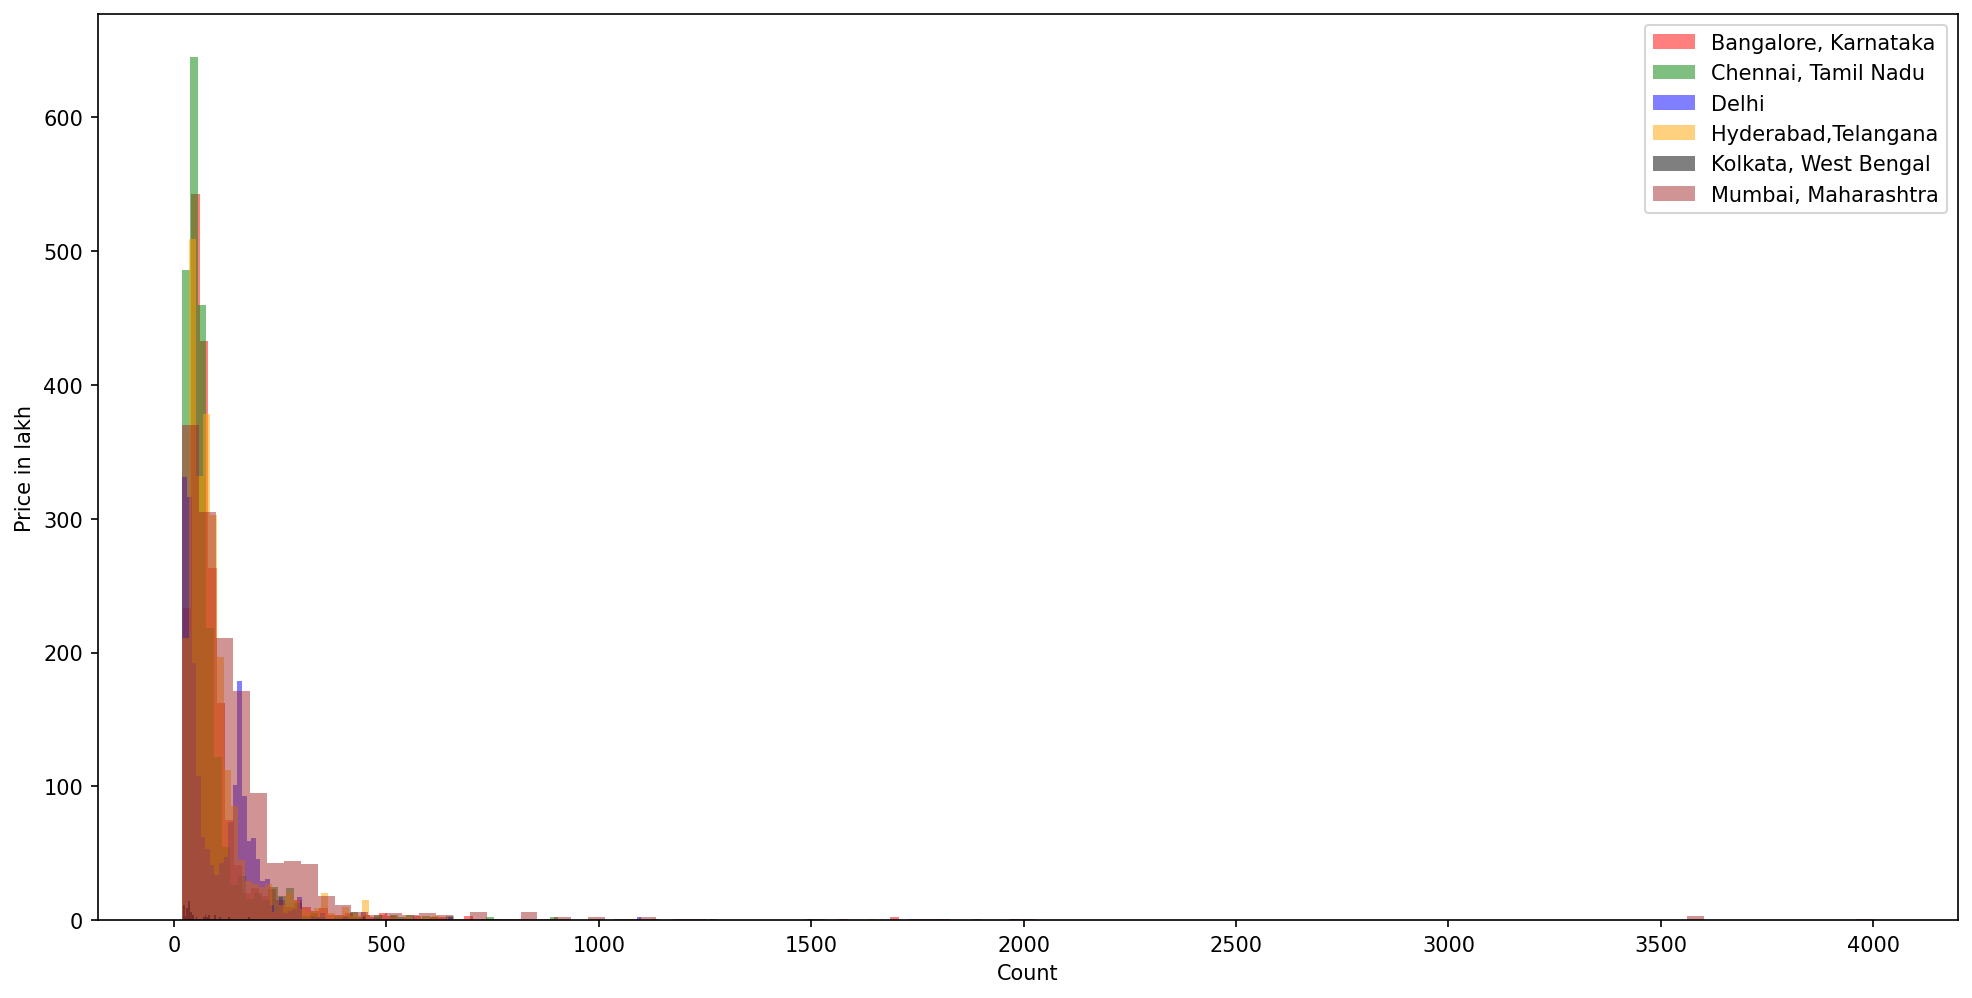

In [8]:
for color,city in zip(['r','g','b','orange','black','brown'],df_nn.City.unique()):
    temp_df = df_nn[df_nn['City']==city]
    plt.hist(temp_df['Price'],color=color,label=city,bins=100,alpha=0.5)
    
plt.ylabel('Price in lakh')
plt.xlabel('Count')
plt.legend()
plt.show()

<h3 style='color:green'>Where are the houses located</h3>

In [9]:
# providers = cx.providers # check providers 

# fig,ax = plt.subplots(figsize=(12,16))

# #plot only unique locations
# df_gdf.drop_duplicates(subset='Location').plot(ax=ax,color='r',markersize =5)

# cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor,crs='EPSG:4326')
# plt.show()


In [10]:


start_loc= (np.mean(df_nn['latitude']),np.mean(df_nn['longitude']))

#map
m_1=folium.Map(location=start_loc,
              tiles='Open Street Map',
              zoom_start=8,
              min_zoom=6)

#heatmap:
HeatMap(data=df_nn[['latitude','longitude']].values,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'},
        radius=25,
        blur=15).add_to(m_1)
m_1



<h3 style='color:green'>What is the Distribution(city and according to house area) of house prices? </h3>

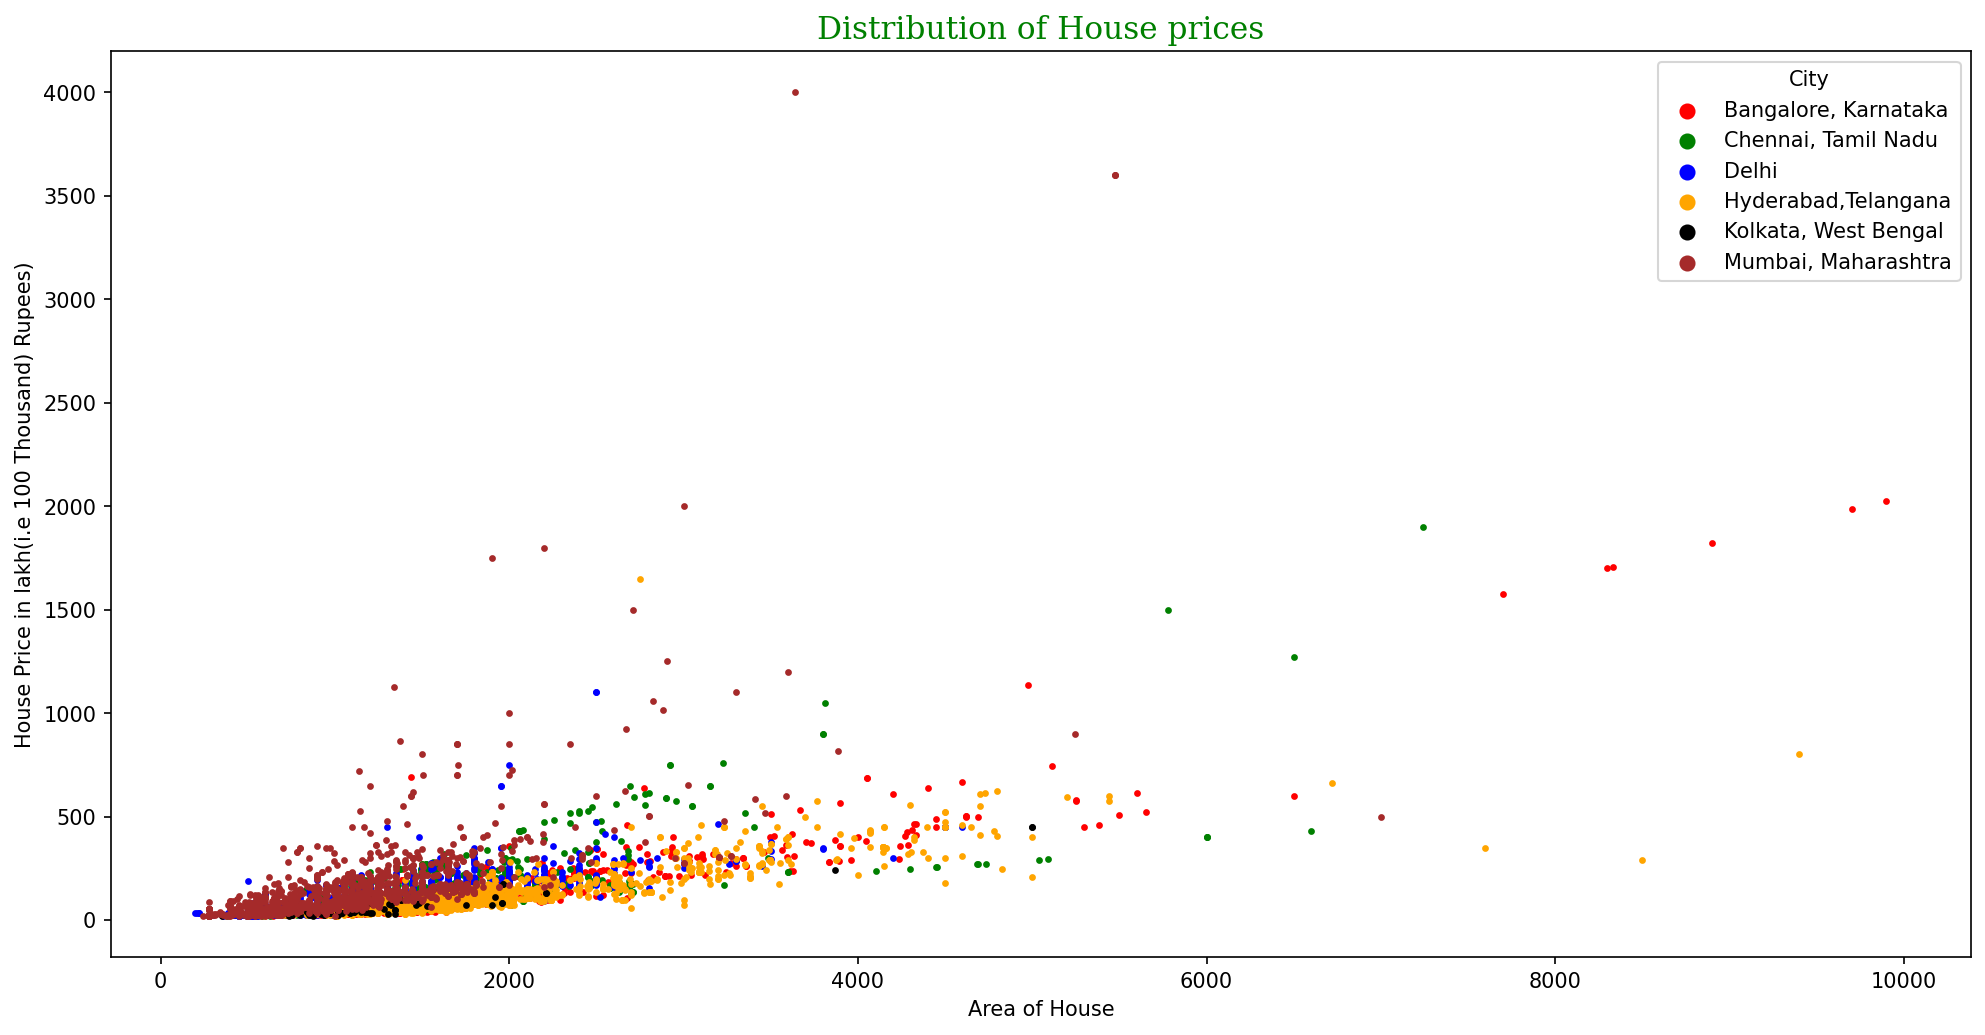

In [11]:

# sns.catplot(x='Area',
#             y="Price",
#             hue='City',
# #             col="Resale",
#             data=df_nn)

for color,city in zip(['r','g','b','orange','black','brown'],df_nn.City.unique()):
    temp_df = df_nn[df_nn['City']==city]
    x, y = temp_df['Area'],temp_df['Price']
    plt.scatter(x,y,color=color,s=5,label=city)
    
plt.xlabel('Area of House')
plt.ylabel('House Price in lakh(i.e 100 Thousand) Rupees)')
plt.title("Distribution of House prices",font="Serif", size=15,color='g')
plt.legend(markerscale=3,title='City')
# plt.xlim(left=0,right=8000)
plt.show()


<h3 style='color:green'>What is the Distribution(geographical and according to Number of Rooms) of house prices? </h3>

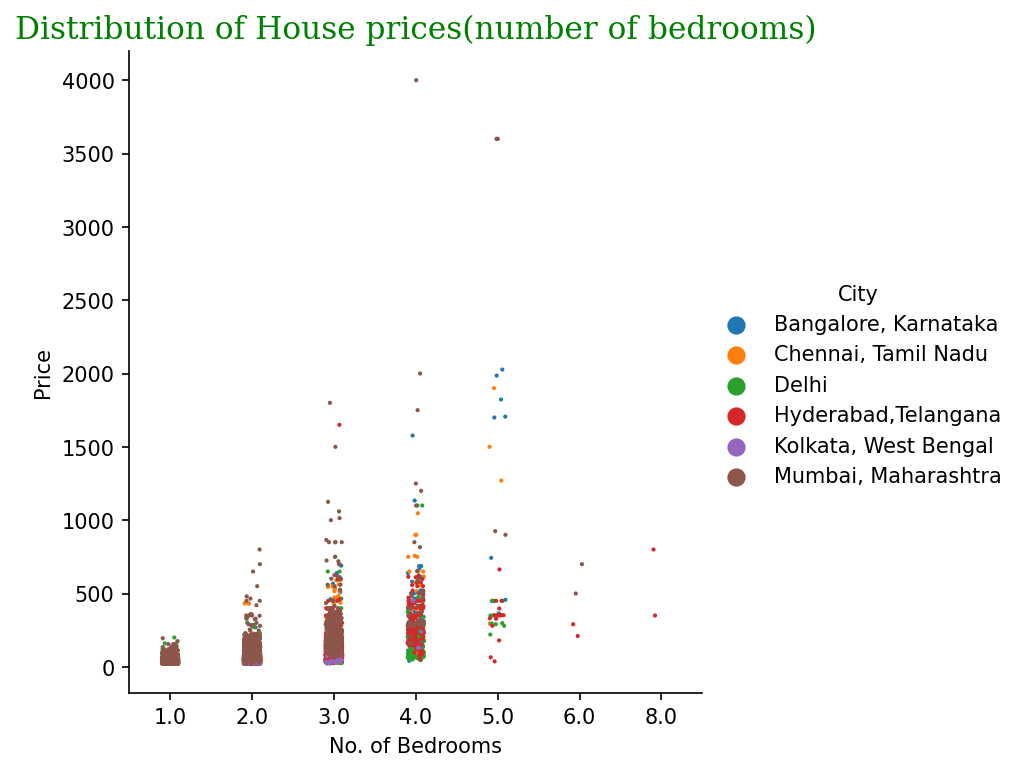

In [12]:

sns.catplot(x='No. of Bedrooms',
            y="Price",
            hue='City',
          data=df_nn,s=2)
plt.title("Distribution of House prices(number of bedrooms)",font="Serif", size=15,color='g')
plt.show()


# How do amenities affect how prices ?

    Calculating the principal components of the amenities columns to answer this question.


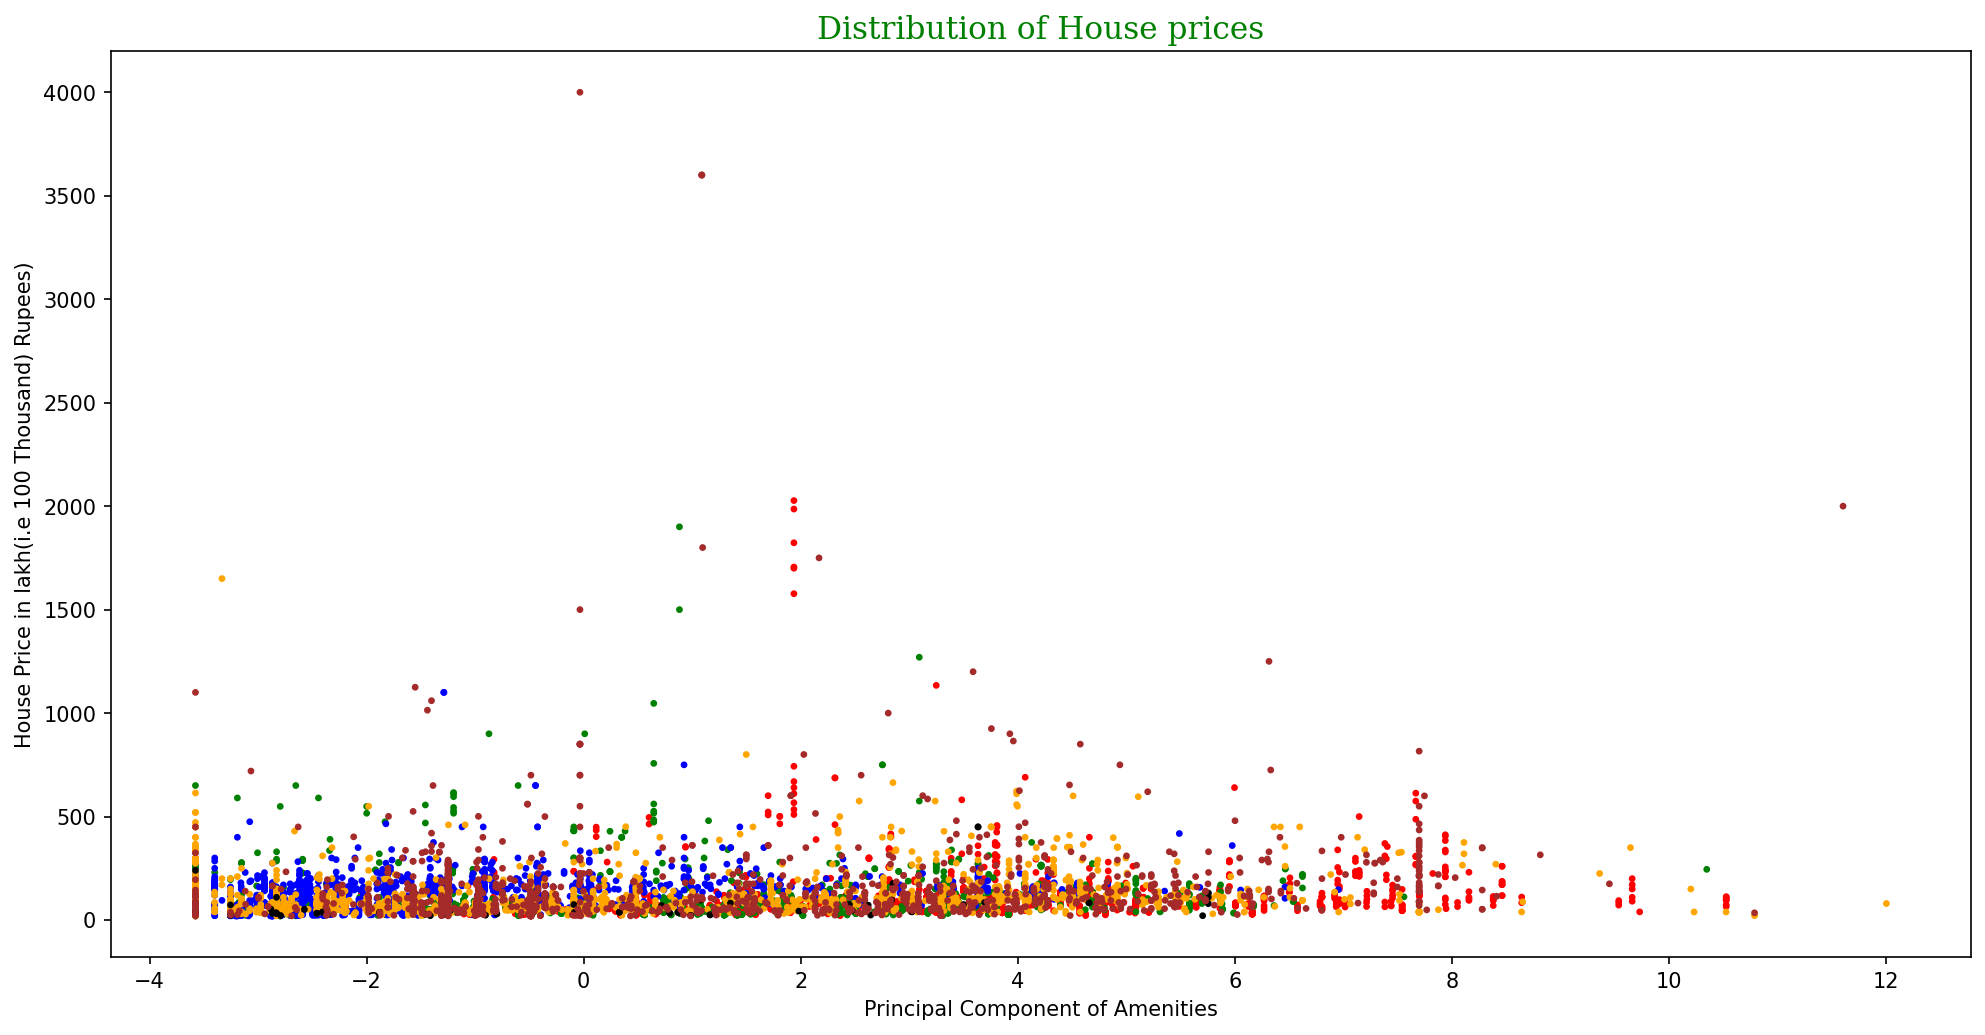

In [13]:


pca_pipeline = Pipeline(steps = [('standard_scaler',StandardScaler()),
                                 ('pca',PCA(n_components=2))
                                 ]
                       )



amenities_cols = ['MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens',
       'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall',
       'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
       '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter',
       'Cafeteria', 'MultipurposeRoom', 'Hospital', 'WashingMachine',
       'Gasconnection', 'AC', 'Wifi', "Children'splayarea", 'LiftAvailable',
       'BED', 'VaastuCompliant', 'Microwave', 'GolfCourse', 'TV',
       'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator']
    

amenities_pc = pd.DataFrame(pca_pipeline.fit_transform(df_nn[amenities_cols]),
                            columns = [f'dim{i}' for i in range(1,3)])

price = df_nn.Price.values
amenities_pc['price'] = price 

#city 
amenities_pc['city'] = df_nn['City'].values


color_map_1 = dict(zip(amenities_pc.city.unique(),['r','g','b','orange','black','brown']))
amenities_pc['color'] = amenities_pc['city'].map(color_map_1)

plt.scatter(amenities_pc['dim1'],amenities_pc['price'],color=amenities_pc['color'],s=5)
    
plt.xlabel('Principal Component of Amenities')
plt.ylabel('House Price in lakh(i.e 100 Thousand) Rupees)')
plt.title("Distribution of House prices",font="Serif", size=15,color='g')
# plt.xlim(left=0,right=8000)
plt.show()


# Split the data into training and test sets

In [14]:
train,test = train_test_split(df_nn,random_state = 7,test_size=0.1)

train.shape,test.shape

((9053, 75), (1006, 75))

# Building a price prediction model

In [65]:
#assign target column
y_train = train['Price']
y_test = test['Price']


In [66]:
#drop the address column 
X_train = train.drop(['Address','Location','Price'],axis=1)
X_test = test.drop(['Address','Location','Price'],axis=1)


categorical_columns = X_train.select_dtypes(include='object').columns.values

#save the cols for use in catboost
cfg.categorical = list(categorical_columns)

#drop geometry 
X_train = X_train.drop('geometry',axis=1)
X_test=X_test.drop('geometry',axis=1)

X_train.shape

(9053, 71)


# Hyperparam optimization


In [67]:
class catboost_optimization:
    def __init__(self,
                 X,
                 y,
                 params=None,
                 categorical = cfg.categorical,
                 seed=cfg.seed):
        self.params = params
        self.seed   = seed
        self.categorical = categorical
        self.X = X
        self.y = y
        

    def objective(self,
                  trial:optuna.Trial):
        
        
        
        self.params = {
                'verbose'        : 1,
               'loss_function'  :'RMSE',
               'depth'          :trial.suggest_int('depth',4,10),
               'learning_rate'  :trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
               'l2_leaf_reg'    :trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
               'random_strength':trial.suggest_uniform('random_strength',1e-2,0.5),
               'max_bin'        :trial.suggest_int('max_bin',64,254),
               'grow_policy'    :trial.suggest_categorical('grow_policy',
                                                           ['SymmetricTree','Depthwise']),
               'iterations'     :trial.suggest_int('iterations',1000,2000),
#                'max_leaves'     :trial.suggest_int('max_leaves',2,64),
               "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.7),
#                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
               "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                           ["Bayesian", "MVS",'Bernoulli']),
               'eval_metric': 'R2'
                }

        #splitting training data 
        x_tr,x_ts,y_tr,y_ts=train_test_split(self.X,
                                             self.y,
                                             random_state=self.seed,
                                             train_size=0.70)
        
# `
        try:
            model = CatBoostRegressor(**self.params)
            
            model.fit(x_tr,y_tr,
                     eval_set=[(x_ts,y_ts)],
                     verbose=0,
                     cat_features=self.categorical,
                     early_stopping_rounds=300)
  

            preds=model.predict(x_ts)

            acc= mean_squared_error(y_ts,preds)

            return acc

        except Exception as e:
            print(e)
            return None
   
    def get_best_params(self,
                        n_trials = 30,
                        time_out=9000,
                        direction= 'minimize'):
        
        print(f'Running optimization for {time_out} seconds / {n_trials} Trials')
        
        
        sampler = optuna.samplers.TPESampler(seed=self.seed)  # Make the sampler behave in a deterministic way.

        self.study=optuna.create_study(direction=direction,
                                        sampler=sampler)
        self.study.optimize(self.objective,
                           n_trials=n_trials,
                           timeout=time_out)

        print("Number of finished trials: {}".format(len(self.study.trials)))

        return self.study.best_trial.params

    def plot_history(self):
        '''plot optimization history :
        credits : https://medium.com/databulls/tps-mar21-leaderboard-14-xgb-catboost-lgbm-optuna-cdffb5124368'''
        optuna.visualization.plot_optimization_history(self.study)
        
    def plot_param_importances(self):
        '''plot param imp'''
        optuna.visualization.plot_param_importances(self.study)

In [68]:
catb_optimizer = catboost_optimization(X=X_train,
                                       y=y_train,
                                       )


best_params = catb_optimizer.get_best_params(n_trials = 50, # number of trials 
                                            time_out=3000, # time out in seconds 
                                            direction= 'minimize')  # run hyperparam optimization



[I 2022-05-31 14:37:40,614] A new study created in memory with name: no-name-d205ad59-8f3d-4d26-8383-ed5ce6798826


Running optimization for 3000 seconds / 50 Trials


[I 2022-05-31 14:37:43,559] Trial 0 finished with value: 3324.4197691304894 and parameters: {'depth': 4, 'learning_rate': 0.021865347140571728, 'l2_leaf_reg': 0.2066463288698664, 'random_strength': 0.3644979371371612, 'max_bin': 250, 'grow_policy': 'SymmetricTree', 'iterations': 1072, 'colsample_bylevel': 0.40737559204074847, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 3324.4197691304894.
[I 2022-05-31 14:37:54,116] Trial 1 finished with value: 16693.12075288386 and parameters: {'depth': 6, 'learning_rate': 0.00015769177465114242, 'l2_leaf_reg': 0.07318748070568248, 'random_strength': 0.4557008285826107, 'max_bin': 104, 'grow_policy': 'Depthwise', 'iterations': 1024, 'colsample_bylevel': 0.540219566985649, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 3324.4197691304894.
[I 2022-05-31 14:38:42,190] Trial 2 finished with value: 13582.321936584309 and parameters: {'depth': 10, 'learning_rate': 0.00025090443458586733, 'l2_leaf_reg': 0.3717386710499825, 'random

Number of finished trials: 50


**Update the best params**

In [69]:
best_params.update({'iterations':3000,
                    'verbose':0})


cfg.best_params = best_params

best_params

{'depth': 7,
 'learning_rate': 0.0774375471736431,
 'l2_leaf_reg': 8.422177193030699,
 'random_strength': 0.2981186751095923,
 'max_bin': 215,
 'grow_policy': 'SymmetricTree',
 'iterations': 3000,
 'colsample_bylevel': 0.6995239618125975,
 'bootstrap_type': 'Bayesian',
 'verbose': 0}

**Fitting Model**

In [72]:
class my_estimator:
    def __init__(self,
                 estimator):
        self.estimator_obj = estimator
        self.estimator_list = []
        
    def fit(self,
            X,
            y,
            params= {},
            categorical=None):
        
        '''fit X,y to the data'''
        
        self.params= params
        self.estimator = self.estimator_obj(**self.params)
        
        if isinstance(categorical,(list,str)):
            self.estimator.fit(X,y,
                               cat_features = categorical)
        else:
            self.estimator.fit(X,y)
            
        return None
            
    def predict(self,X_test):
        '''predict using estimator'''
        
        if not self.estimator:
            print("Fit the model using 'model.fit(X,y)' first!")
            
        return self.estimator.predict(X_test)
    
    def fit_in_folds(self,
                     X,
                     y,
                     categorical=None,
                     params={},
                     eval_metric = mean_squared_error,
                     cv=KFold(n_splits=10)):
        '''fit multiple models using k-fold cross validation strategy'''
        self.n =1
        self.params = params
           

        for train_idx,val_idx in cv.split(X,y):

            x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
            y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]

            self.estimator=self.estimator_obj(**self.params)    

            print(f'fitting on fold {self.n} ')

            if isinstance(categorical,(list,str)):
                self.estimator.fit(x_t,y_t,
                                   cat_features = categorical)
            else:
                self.estimator.fit(x_t,y_t)

            
            
            
            print('Validation score for fold {} is {}'.format(self.n,eval_metric(y_v,
                                                                           self.estimator.predict(x_v)
                                                                          )
                                                              )
                 )
            
            
            
            self.n+=1

            self.estimator_list.append(self.estimator) # store fitted models

            

        return None

    def predict_in_folds(self,
                         X_test):
        
        if len(self.estimator_list) <1:
            print("Fit the data on multiple folds by calling 'model.fit_in_folds(X,y)' ")
        else:
            predictions_list = []
            for model in self.estimator_list:
                pred = model.predict(X_test)
                
                predictions_list.append(pred)
                
            predictions = np.array(predictions_list).T  # (n,m) dim array, where n is number of examples and m is number of models
        
        
        return predictions
            
    def aggregate_predictions(self,
                              predictions,
                              agg='mean'):
        '''aggregate predictions'''
        
        
        if agg == 'mean':
            return predictions.mean(axis=1)
        elif agg == 'median':
            return np.median(a= predictions,
                             axis=1)
                   
        else:
            print("assign 'agg' to either of ['mean','median']")
            
            return None
            

In [73]:
%%time


#create a instance of estimator
estimator = my_estimator(estimator=CatBoostRegressor)


#fit on multiple folds 
estimator.fit_in_folds(X = X_train,
                       y = y_train,
                      categorical=cfg.categorical,
                      params=cfg.best_params,
                      eval_metric = mean_squared_error,
                      cv=KFold(n_splits=7)
                      )

fitting on fold 1 
Validation score for fold 1 is 1078.347201782015
fitting on fold 2 
Validation score for fold 2 is 8243.675637352479
fitting on fold 3 
Validation score for fold 3 is 1602.221387017362
fitting on fold 4 
Validation score for fold 4 is 3607.6902882518557
fitting on fold 5 
Validation score for fold 5 is 1915.2339233276318
fitting on fold 6 
Validation score for fold 6 is 5308.119096194105
fitting on fold 7 
Validation score for fold 7 is 2070.708121073003
CPU times: user 13min 3s, sys: 3min 28s, total: 16min 32s
Wall time: 4min 33s


**Checking variable importance**

In [81]:
!pip install eli5 --upgrade -q

  Attempting uninstall: eli5
    Found existing installation: eli5 0.11.0
    Uninstalling eli5-0.11.0:
      Successfully uninstalled eli5-0.11.0


In [83]:
#top 20 features 
import eli5.catboost as eli_cb 

eli_cb.explain_weights_catboost(estimator.estimator_list[0])

Weight,Feature
0.4240,Area
0.0921,longitude
0.0524,No. of Bedrooms
0.0426,population_1975
0.0284,HDC_1975
0.0279,No Builtup
0.0223,latitude
0.0223,rel_bai
0.0204,HDC_2014
0.0181,population_2015


**Prediction on test set**

In [84]:


# prediction on validation data
predictions_val = estimator.predict_in_folds(X_test = X_test)


#get mean value of predictions
mean_pred_val = estimator.aggregate_predictions(predictions_val,
                                                agg='mean')
print(f'R2 score of mean value pred on test set is {r2_score(y_test,mean_pred_val)}')
print(f'mean squared error of mean value pred on test set is {mean_squared_error(y_test,mean_pred_val)}')


#get median value of predictions
med_pred_val = estimator.aggregate_predictions(predictions_val,
                                                agg='median')
print(f'R2 score of median value pred on test set is {r2_score(y_test,med_pred_val)}')
print(f'mean squared error of median value pred on test set is {mean_squared_error(y_test,med_pred_val)}')



R2 score of mean value pred on test set is 0.9411752611008865
mean squared error of mean value pred on test set is 516.8396760440648
R2 score of median value pred on test set is 0.9464538876467203
mean squared error of median value pred on test set is 470.46116786937677
